# Regression

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from tqdm import tqdm

plt.ion()

## Data Preperation

In [2]:
import sys
sys.path.append('../../data')
from corpus import load_corpus
data = load_corpus('weebit')

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

Using TensorFlow backend.


## Classical ML

In [3]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


def train_regression_model(model_class, X_train, y_train, model_params={}, hyperparameters_grid={}):
    
    name = model_class.__name__
    
    if 'kernel' in model_params:
        name += ' ' + model_params['kernel']

    try:
        model = model_class(random_state=42, **model_params)
    except TypeError:
        model = model_class(**model_params)

    if hyperparameters_grid:
        model = GridSearchCV(model, hyperparameters_grid)
    
    model.fit(X_train, y_train)
    
    return name, model


ALPHAs = 10.**np.arange(-4, 5)
Cs = 10.**np.arange(-4, 5)
    
models = dict([train_regression_model(model_class, X_train, y_train, model_params, hyperparameters_grid)
          for model_class, model_params, hyperparameters_grid in
                                     tqdm([
                                         (LinearRegression, {},  {}),
                                         (RidgeCV, {'alphas': ALPHAs}, {}),
                                         (LassoCV, {}, {}),
                                         (LinearSVR, {}, {'C': Cs}),
                                         (SVR, {'kernel': 'rbf'}, {'C': Cs}),
                                         (SVR, {'kernel': 'poly'}, {'C': Cs}),
                                         (SVR, {'kernel': 'sigmoid'}, {'C': Cs}),
                                       #  (RandomForestRegressor, {}, {'n_estimators': range(10, 101, 50), #10
                                       #                           'max_features': ['auto', 'sqrt'],
                                       #                           'max_depth': range(10, 101, 50)}), #10
                                        (GradientBoostingRegressor, {}, {}),
                                     ])])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:52<00:00, 21.58s/it]


## MLP

In [4]:
!export CUDA_VISIBLE_DEVICES=0

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

from livelossplot import PlotLossesKeras

n_features = X_train.shape[1]

In [6]:
"""
model = Sequential()
model.add(Dense(1, input_shape=(n_features,), kernel_regularizer=regularizers.l2(0.01)))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=500, verbose=0, callbacks=[PlotLossesKeras()], validation_split=0.1,)

print(history.history['val_loss'][-1])
""";

In [7]:
"""
model = Sequential()
model.add(Dense(16, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=500, verbose=0, callbacks=[PlotLossesKeras()], validation_split=0.1,)

print(history.history['val_loss'][-1])
""";

In [8]:
"""
model = Sequential()
model.add(Dense(128, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=500, verbose=0, callbacks=[PlotLossesKeras()], validation_split=0.1,)

print(history.history['val_loss'][-1])
""";

In [9]:
def train_mlp(units):
    model = Sequential()
    model.add(Dense(units, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, epochs=200, verbose=0)#, validation_split=0.1,)
    
    return model


models['MLP 16'] = train_mlp(16)
models['MLP 32'] = train_mlp(32)
models['MLP 64'] = train_mlp(64)
models['MLP 128'] = train_mlp(128)

In [10]:
deep_model = Sequential()
deep_model.add(Dense(256, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))

deep_model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

deep_model.fit(X_train, y_train, epochs=100, verbose=0)

models['MLP-deep'] = deep_model

## Evaluation

In [11]:
import itertools
import functools
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score,\
                            classification_report, accuracy_score, confusion_matrix, f1_score


def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

   
def calc_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    
    y_pred_classes = np.clip(y_pred.round().astype(int), 0, 4)

    metrics = {}

    metrics.update({metrics.__name__: metrics(y_test, y_pred) for metrics in [mean_absolute_error,
                                                                      mean_squared_error,
                                                                      explained_variance_score,                                                                      explained_variance_score,
                                                                      r2_score
                                                                      
    ]})
    
    metrics.update({metrics.__name__: metrics(y_test, y_pred_classes) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]})

    return metrics

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

In [12]:
summary_evaluation_df = (evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre', 'mean_absolute_error', 'mean_squared_error', 'explained_variance_score', 'r2_score']]
     .astype(float).round(4))
summary_evaluation_df

,accuracy_score,f1_score_micro,threshold_socre,mean_absolute_error,mean_squared_error,explained_variance_score,r2_score
MLP 128,0.5192,0.5192,0.9409,0.5999,0.5908,0.6951,0.6945
MLP 64,0.5522,0.5522,0.9382,0.5971,0.6146,0.6822,0.6822
MLP 32,0.5165,0.5165,0.9341,0.6252,0.6409,0.6715,0.6686
MLP 16,0.5440,0.5440,0.9327,0.5961,0.6132,0.6829,0.6829
MLP-deep,0.5975,0.5975,0.9327,0.5397,0.5753,0.7030,0.7025
SVR rbf,0.5151,0.5151,0.9313,0.6131,0.6437,0.6672,0.6671
GradientBoostingRegressor,0.4698,0.4698,0.9203,0.6638,0.7279,0.6237,0.6236
LinearSVR,0.4753,0.4753,0.9148,0.7088,0.8075,0.5824,0.5824
LinearRegression,0.4533,0.4533,0.9121,0.7186,0.8133,0.5800,0.5794
LassoCV,0.4547,0.4547,0.9107,0.7185,0.8115,0.5810,0.5804


In [13]:
summary_evaluation_df.to_excel('regression_evaluation.xlsx')

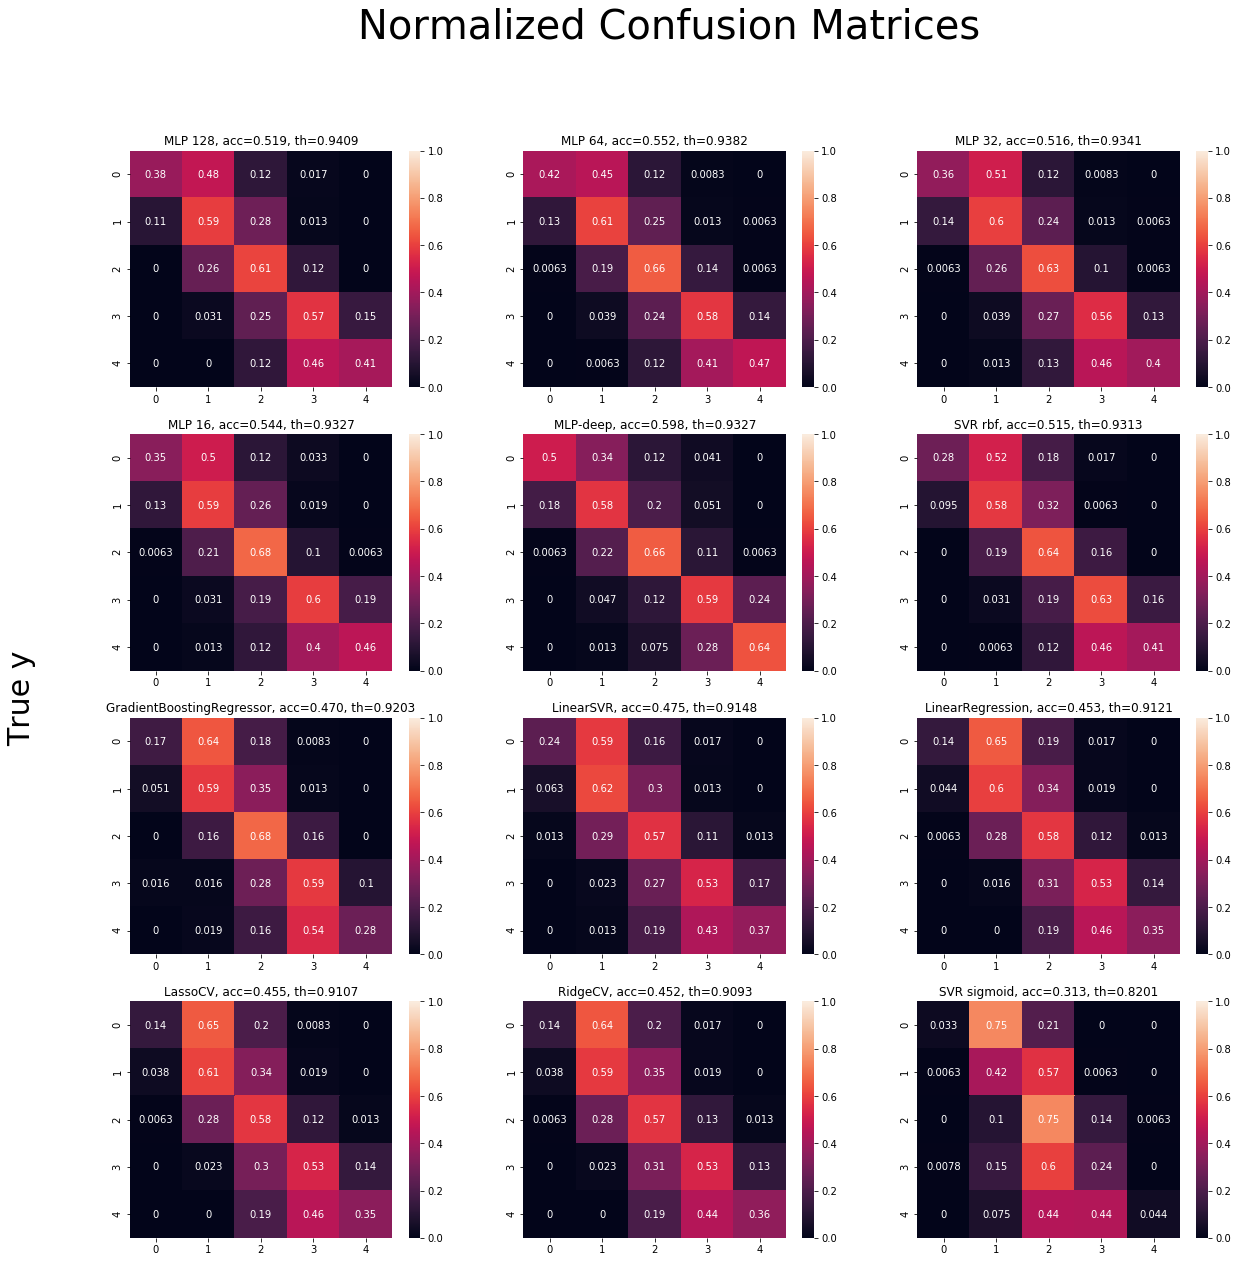

In [14]:
f, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):
    cm = r['confusion_matrix']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmin=0, vmax=1, annot=True,
                ax=ax)
    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))

f.text(0.04, 0.5, 'True y', va='center', rotation='vertical', fontsize=30)
f.suptitle('Normalized Confusion Matrices', fontsize=40);

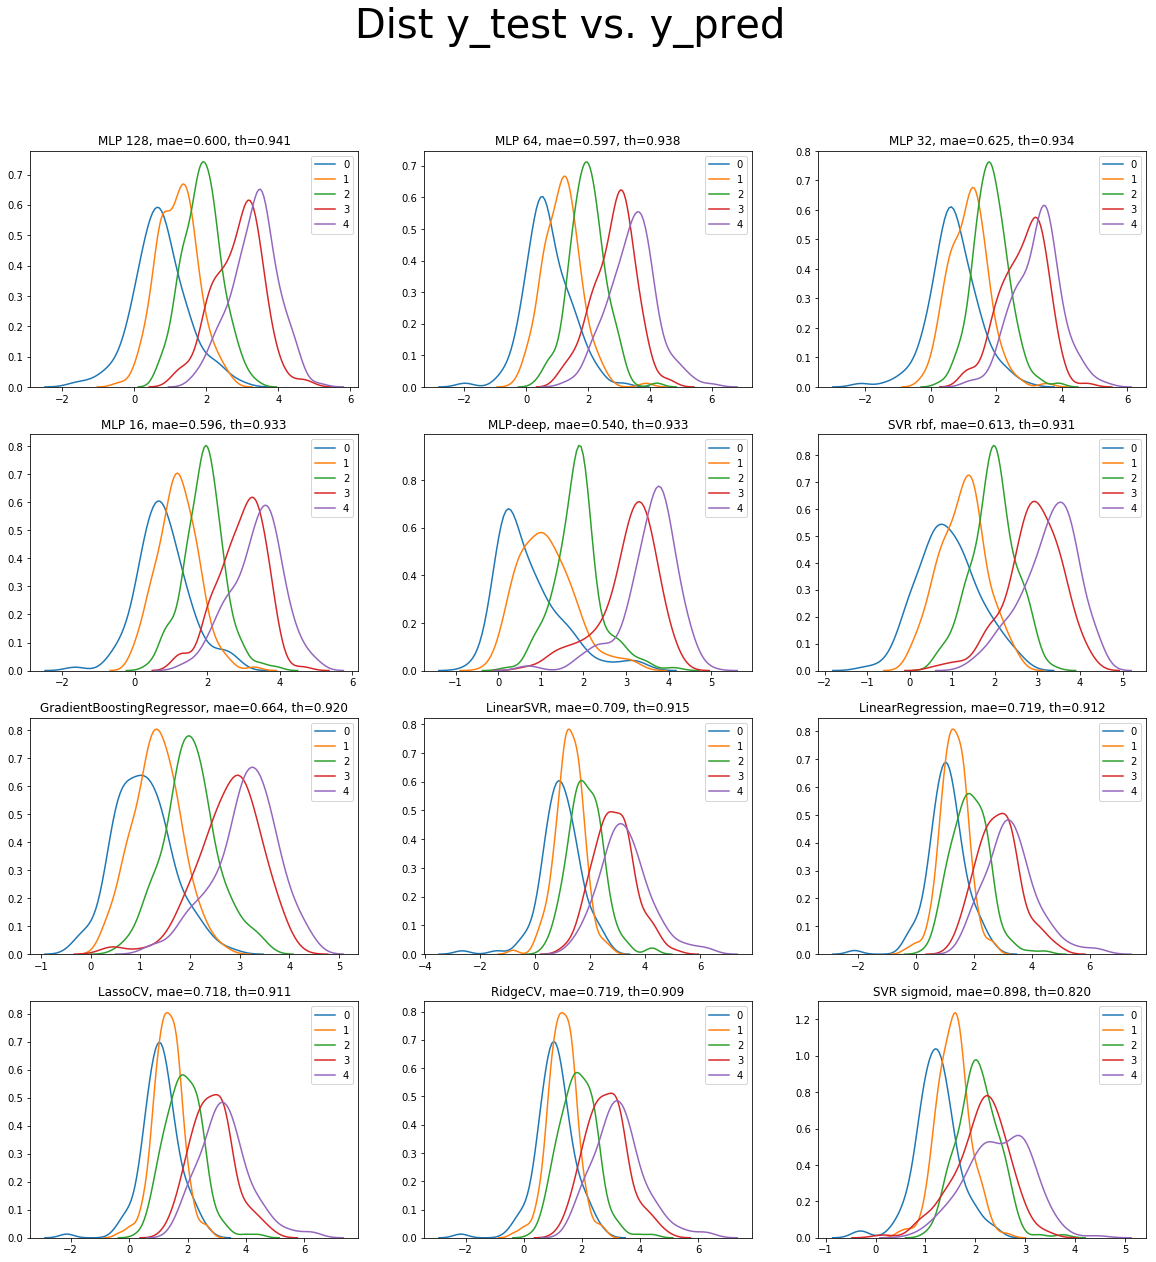

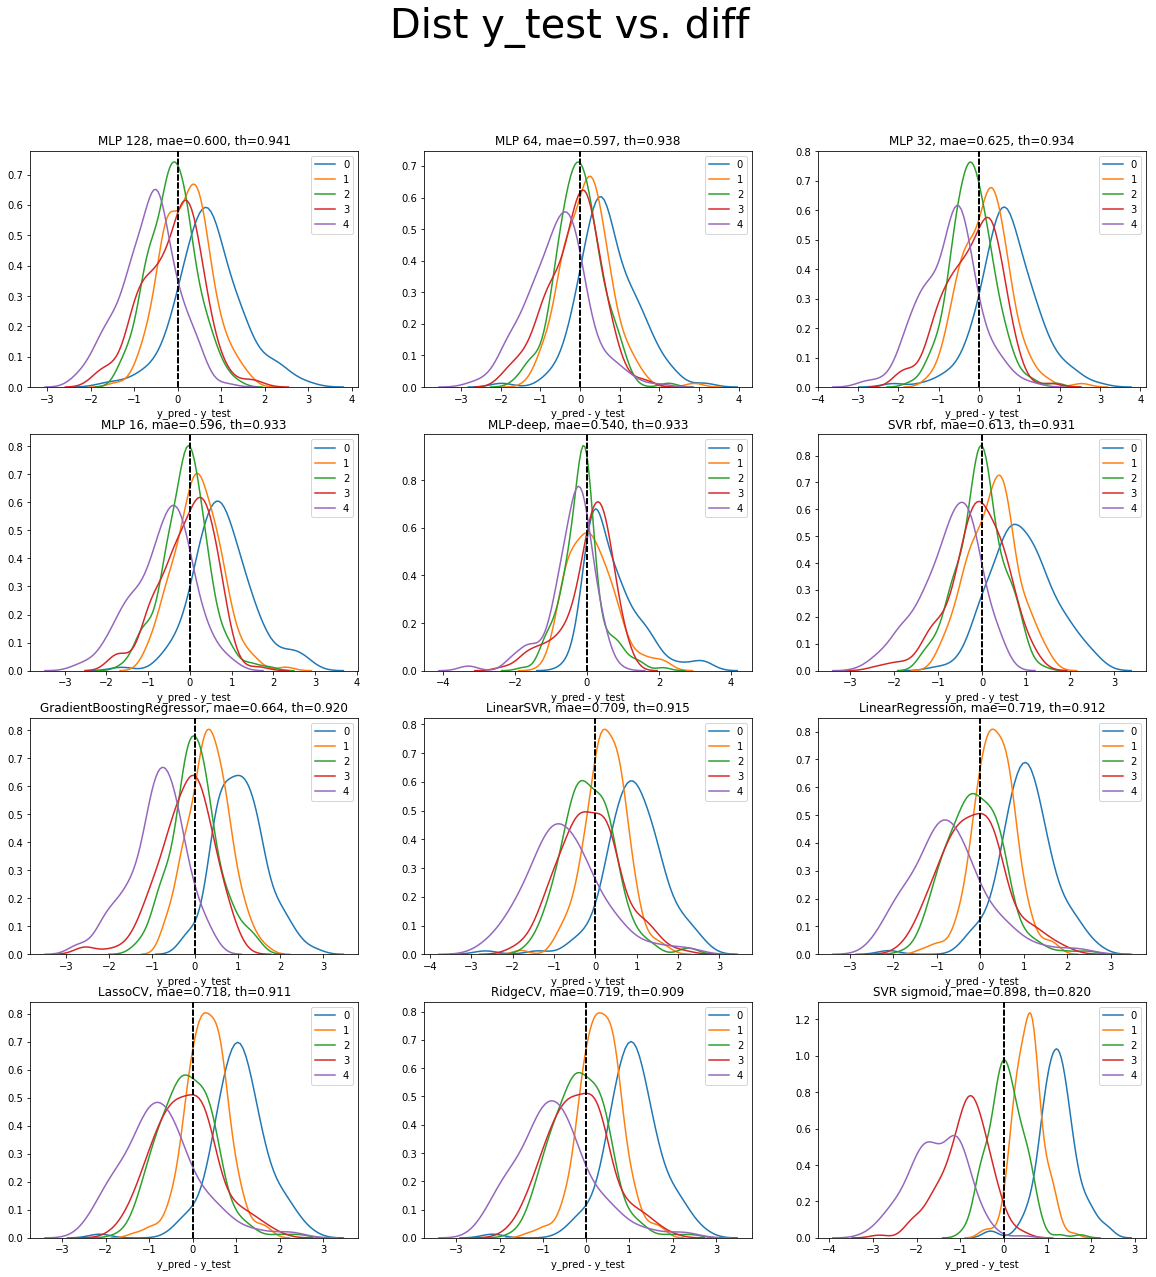

In [15]:
f1, axes1 = plt.subplots(4, 3, figsize=(20, 20))
f2, axes2 = plt.subplots(4, 3, figsize=(20, 20))

axes1 = itertools.chain(*axes1)
axes2 = itertools.chain(*axes2)

for (name, r), ax1, ax2 in zip(evaluation_df.iterrows(), axes1, axes2):

    model = models[name]
    
    y_pred = model.predict(X_test).flatten()
    diff = y_pred - y_test

    for y_value in range(0, 5):
        sns.distplot(y_pred[y_test==y_value], hist=False, label=y_value, ax=ax1)
        ax2.set_xlabel('y_pred')
        
        sns.distplot(diff[y_test==y_value], hist=False, label=y_value, ax=ax2)
        
        ax2.axvline(0, linestyle='--', color='black')
        ax2.set_xlabel('y_pred - y_test')
        ax1.set_title(name + ', mae={:0.3f}, th={:0.3f}'.format(
            *r[['mean_absolute_error', 'threshold_socre']]))
        ax2.set_title(name + ', mae={:0.3f}, th={:0.3f}'.format(
            *r[['mean_absolute_error', 'threshold_socre']]))
        
f1.suptitle('Dist y_test vs. y_pred', fontsize=40);
f2.suptitle('Dist y_test vs. diff', fontsize=40);